In [4]:
import pandas as pd

In [5]:
df_heart = pd.read_csv("/Users/manuelrodriguezsutil/Developer/health-risk/data/heart_disease_cleaned.csv")

In [6]:
df_heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,53.510870,0.789130,3.250000,132.409783,243.102174,0.937174,0.604348,136.889565,0.394783,0.910478,1.757609,0.778913,5.371522,0.553261
std,9.424685,0.408148,0.930969,18.048882,47.837030,0.203368,0.804978,25.438033,0.477178,1.039830,0.539280,0.667765,1.508660,0.497426
min,28.000000,0.000000,1.000000,80.000000,100.000000,0.200000,0.000000,60.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,216.000000,1.000000,0.000000,120.000000,0.000000,0.000000,1.200000,0.200000,3.800000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,238.000000,1.000000,0.000000,138.000000,0.000000,0.600000,2.000000,0.800000,6.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,266.000000,1.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.200000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,491.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
df_heart_encoded = pd.get_dummies(
    df_heart,
    columns=['cp', 'restecg', 'slope', 'thal'],
    drop_first=True
)

In [9]:
features_heart = [col for col in df_heart_encoded.columns if col not in ['target', 'source']]
X = df_heart_encoded[features_heart]
y = df_heart_encoded['target']

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X = X_scaled
y = df_heart_encoded['target']

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [14]:
rf = RandomForestClassifier(random_state=42)

In [15]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [17]:
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF AUC:", roc_auc_score(y_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

RF Accuracy: 0.8206521739130435
RF AUC: 0.9106886657101865
Confusion Matrix:
 [[59 23]
 [10 92]]


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

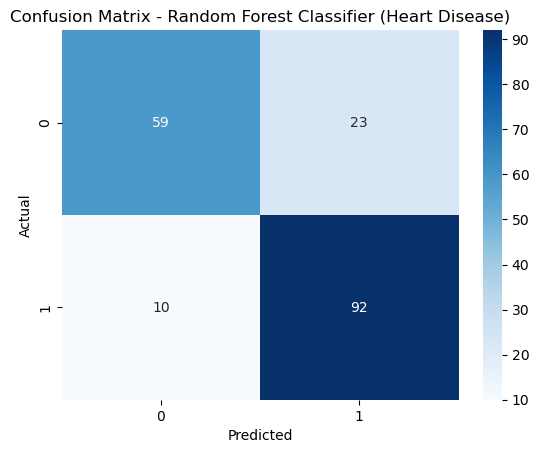

In [19]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest Classifier (Heart Disease)")
plt.savefig("/Users/manuelrodriguezsutil/Developer/health-risk/visuals/heart_disease/confusion_matrix_rf.png", dpi=300)
plt.show()

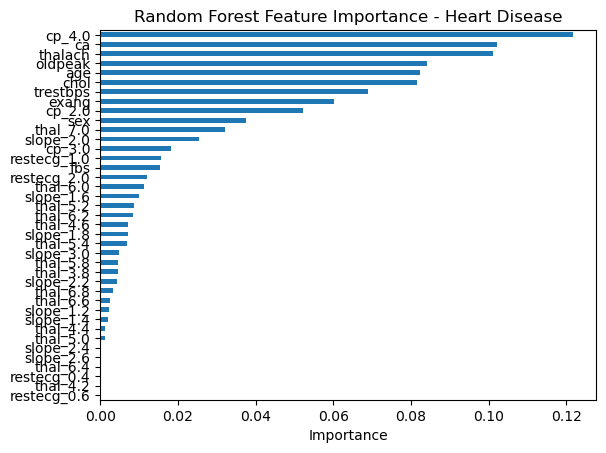

In [20]:
importances = pd.Series(rf.feature_importances_, index=features_heart)
importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Random Forest Feature Importance - Heart Disease")
plt.xlabel("Importance")
plt.savefig("/Users/manuelrodriguezsutil/Developer/health-risk/visuals/heart_disease/rf_importance.png")
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

In [23]:
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [24]:
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

In [25]:
y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

In [26]:
print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred_best))
print("Tuned RF AUC:", roc_auc_score(y_test, y_proba_best))
print("Best Params:", grid_search.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Tuned RF Accuracy: 0.8206521739130435
Tuned RF AUC: 0.9177427068388331
Best Params: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 200}
Confusion Matrix:
 [[58 24]
 [ 9 93]]


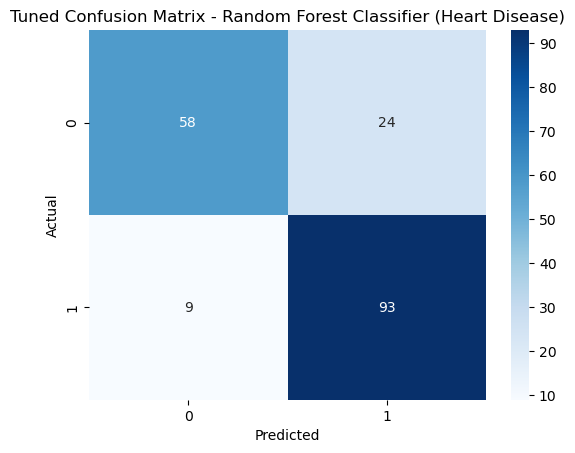

In [27]:
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Tuned Confusion Matrix - Random Forest Classifier (Heart Disease)")
plt.savefig("/Users/manuelrodriguezsutil/Developer/health-risk/visuals/heart_disease/tuned_confusion_matrix_rf.png", dpi=300)
plt.show()

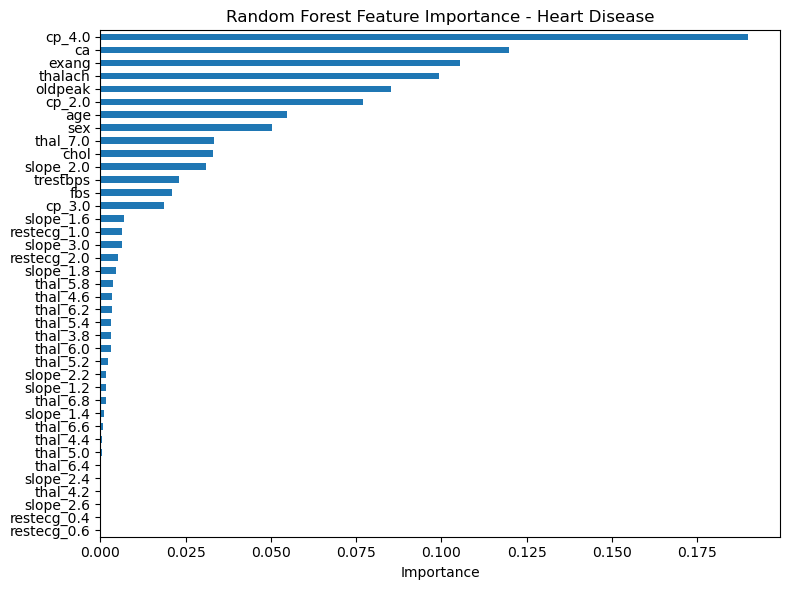

In [28]:
rf_importances = pd.Series(best_rf.feature_importances_, index=features_heart)
rf_importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6))
plt.title("Random Forest Feature Importance - Heart Disease")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("/Users/manuelrodriguezsutil/Developer/health-risk/visuals/heart_disease/rf_importance.png", dpi=300)
plt.show()

In [29]:
import shap

In [46]:
X_test_df = pd.DataFrame(X_test, columns=features_heart)

In [49]:
explainer = shap.Explainer(best_rf, X_test_df)

In [52]:
shap_values = explainer(X_test_df, check_additivity=False)

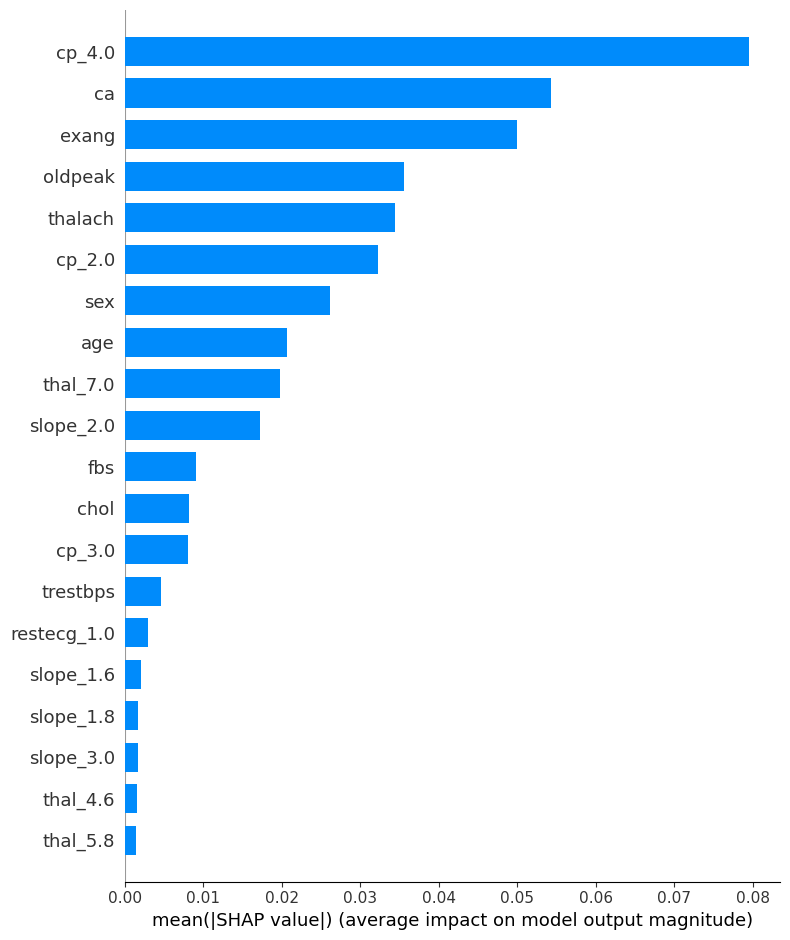

In [56]:
shap.summary_plot(shap_values.values[:, :, 1], X_test_df, plot_type="bar")
plt.savefig("/Users/manuelrodriguezsutil/Developer/health-risk/visuals/heart_disease/shap_summary_bar.png", dpi=300)
plt.close()

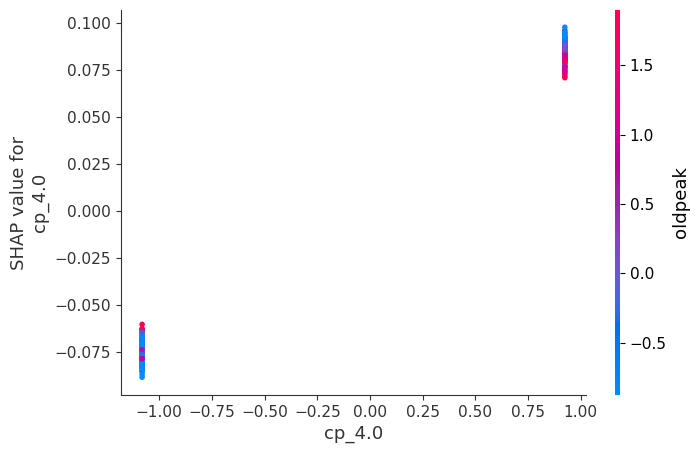

In [62]:
shap.dependence_plot("cp_4.0", shap_values.values[:, :, 1], X_test_df)
plt.savefig("/Users/manuelrodriguezsutil/Developer/health-risk/visuals/heart_disease/shap_dependence_chest_pain.png", dpi=300)
plt.close()

In [65]:
shap.initjs()

In [83]:
shap_values = explainer(X_test_df)

In [110]:
shap.plots.force(explainer.expected_value[0], shap_values.values[0])

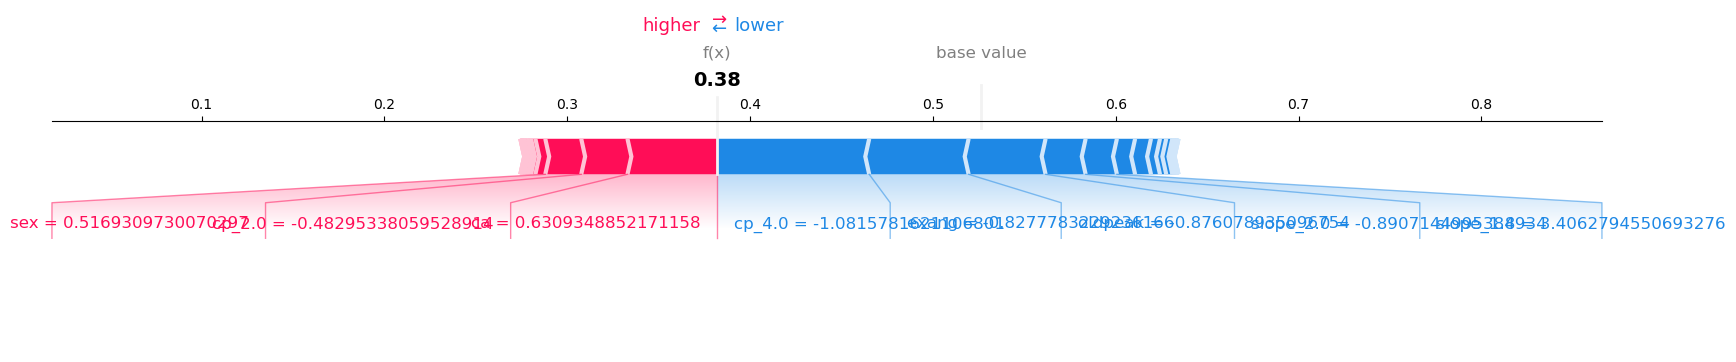

In [122]:
shap.force_plot(
    explainer.expected_value[1],
    shap_values.values[28, :, 1],
    X_test_df.iloc[28],
    matplotlib=True
)

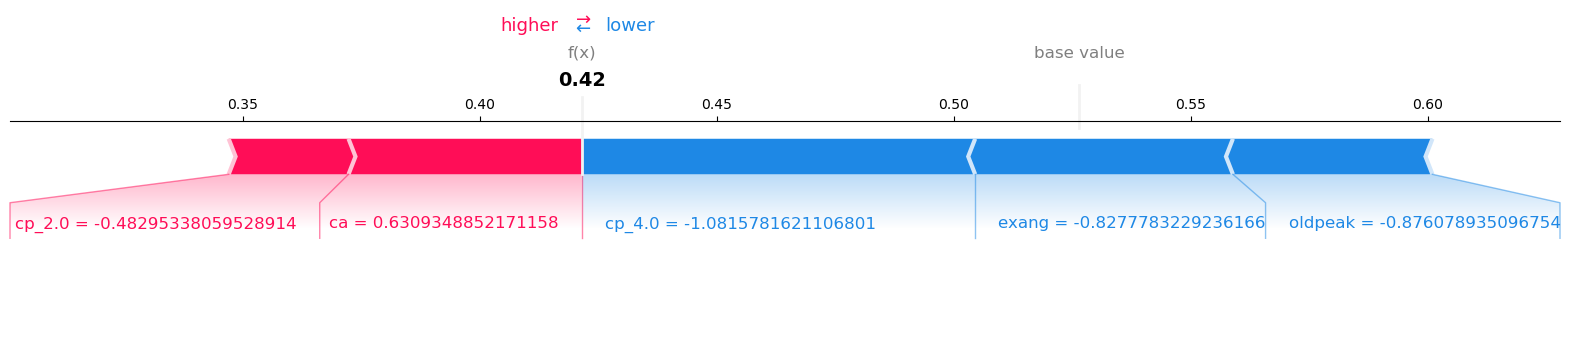

In [153]:
import numpy as np

shap_vals = shap_values.values[28, :, 1].copy()
top_n = 5
top_indices = np.argsort(np.abs(shap_vals))[-top_n:]
filtered_shap_vals = np.zeros_like(shap_vals)
filtered_shap_vals[top_indices] = shap_vals[top_indices]

shap.force_plot(
    explainer.expected_value[1],
    filtered_shap_vals,
    X_test_df.iloc[28],
    matplotlib=True
)

plt.gcf().set_size_inches(12, 2)
plt.savefig("/Users/manuelrodriguezsutil/Developer/health-risk/visuals/heart_disease/force_plot_patient_28.png", dpi=300, bbox_inches="tight")
plt.close()

In [157]:
X_test_df.iloc[28][["cp_2.0", "ca", "cp_4.0", "exang", "oldpeak"]]

cp_2.0    -0.482953
ca         0.630935
cp_4.0    -1.081578
exang     -0.827778
oldpeak   -0.876079
Name: 28, dtype: float64

In [162]:
import joblib

In [164]:
joblib.dump(best_rf, "/Users/manuelrodriguezsutil/Developer/health-risk/models/heart_rf.pkl")
joblib.dump(scaler, "/Users/manuelrodriguezsutil/Developer/health-risk/models/heart_scaler.pkl")

['/Users/manuelrodriguezsutil/Developer/health-risk/models/heart_scaler.pkl']